In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from transformers import get_scheduler
from datasets import load_dataset
import evaluate
import numpy as np
import time
import csv
from tqdm import tqdm
import torch.nn.utils.prune as prune
import os
import pandas as pd



In [2]:
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 고정된 시드 설정
set_seed(42)

In [3]:
# 데이터셋 로드 및 토큰화
dataset = load_dataset("glue", "sst2")
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')


In [4]:
def tokenize_function(examples):
    return tokenizer(examples['sentence'], padding='max_length', truncation=True)


In [5]:
tokenized_datasets = dataset.map(tokenize_function, remove_columns=['sentence', 'idx'], batched=True)
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

train_dataset = tokenized_datasets['train']
eval_dataset = tokenized_datasets['validation']

In [6]:
#how to split train_dataset into train_dataset and eval_dataset
#train_dataset2 = tokenized_datasets['train'].select(range(100))

In [7]:
#train_dataset2

In [8]:
#train_dataloader2 = DataLoader(train_dataset2, batch_size=32)


In [9]:
# PyTorch DataLoader 생성
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=32)
#train dataset 0.1만큼을 validation dataset으로 사용
#train_dataset2, test_train_dataset = train_dataset.train_test_split(test_size=0.1)
#train_dataloader2 = DataLoader(test_train_dataset, batch_size=32, shuffle=True)
#test_train_dataloader = DataLoader(, batch_size=32)

In [10]:
# 모델 로드 및 GPU 설정
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [11]:
# 옵티마이저와 스케줄러 설정
def get_optimizer_and_scheduler(model, num_training_steps):
    optimizer = optim.AdamW(model.parameters(), lr=1e-5)
    lr_scheduler = get_scheduler(
        name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
    )
    return optimizer, lr_scheduler

In [12]:
# 평가 메트릭 설정
metric = evaluate.load("accuracy")

def compute_metrics(predictions, labels):
    preds = np.argmax(predictions, axis=-1)
    return metric.compute(predictions=preds, references=labels)


In [13]:
# 프루닝 함수
def prune_model(model, amount):
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=amount)


In [14]:
# 프루닝된 가중치를 COO 포맷으로 저장
def save_pruned_weights_in_coo_format(model, prune_amount):
    pruned_weights_dir = f"pruned_weights_coo/{prune_amount}"
    os.makedirs(pruned_weights_dir, exist_ok=True)
    
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            weight = module.weight.detach().cpu()
            # 프루닝된 가중치 텐서를 희소 텐서로 변환
            coo_weight = weight.to_sparse_coo()
            # 파일로 저장 (torch 형식으로 저장)
            torch.save(coo_weight, os.path.join(pruned_weights_dir, f"{name}_weight_coo.pth"))


In [15]:
# 프루닝된 가중치를 로드
def load_pruned_weights(model, prune_amount):
    pruned_weights_dir = f"pruned_weights_coo/{prune_amount}"
    
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            coo_weight = torch.load(os.path.join(pruned_weights_dir, f"{name}_weight_coo.pth"))
            module.weight = torch.nn.Parameter(coo_weight.to_dense())

In [16]:
def train_and_evaluate(model, train_dataloader, eval_dataloader, amp_enabled, num_epochs=20):
    optimizer, lr_scheduler = get_optimizer_and_scheduler(model, num_epochs * len(train_dataloader))
    scaler = torch.amp.GradScaler(enabled=amp_enabled)

    best_acc = 0
    early_stop_counter = 0
    early_stop_patience = 3
    min_epochs = 5
    
    epoch_times = []  # 에폭마다의 학습 시간을 저장할 리스트
    
    # 학습 루프
    for epoch in range(num_epochs):
        epoch_start_time = time.time()  # 에폭 시작 시간 기록

        model.train()
        loop = tqdm(train_dataloader, leave=True)
        for batch in loop:
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()

            with torch.amp.autocast(device_type='cuda', enabled=amp_enabled):
                outputs = model(**batch)
                loss = outputs.loss
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            lr_scheduler.step()

            loop.set_description(f'Epoch {epoch + 1}')
            loop.set_postfix(loss=loss.item())

        epoch_time = time.time() - epoch_start_time  # 에폭 종료 시간 기록 및 에폭 학습 시간 계산
        epoch_times.append(epoch_time)  # 에폭 시간을 리스트에 저장

        # 평가 루프
        model.eval()
        all_predictions = []
        all_labels = []
        eval_loop = tqdm(eval_dataloader, leave=True)
        with torch.no_grad():
            for batch in eval_loop:
                batch = {k: v.to(device) for k, v in batch.items()}
                with torch.amp.autocast(device_type='cuda', enabled=amp_enabled):
                    outputs = model(**batch)
                logits = outputs.logits
                labels = batch["labels"]
                all_predictions.append(logits.cpu().numpy())
                all_labels.append(labels.cpu().numpy())
                eval_loop.set_description(f'Evaluation')

        all_predictions = np.concatenate(all_predictions, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)
        metrics = compute_metrics(all_predictions, all_labels)
        eval_acc = metrics['accuracy']
        print(f"Epoch {epoch + 1} - Accuracy: {eval_acc:.4f}")

        # Early Stopping 조건 체크
        if epoch >= min_epochs:
            if eval_acc > best_acc:
                best_acc = eval_acc
                early_stop_counter = 0
            else:
                early_stop_counter += 1

            if early_stop_counter >= early_stop_patience:
                print("Early stopping triggered")
                break

    # 추론 시간 측정
    start_time = time.time()
    model.eval()
    with torch.no_grad():
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.amp.autocast(device_type='cuda', enabled=amp_enabled):
                outputs = model(**batch)
    inference_time = time.time() - start_time

    # 메모리 사용량 측정
    memory_usage = torch.cuda.max_memory_allocated(device) / 1024**2  # Convert to MB

    # 에폭당 평균 학습 시간 계산
    avg_epoch_time = sum(epoch_times) / len(epoch_times)

    return best_acc, avg_epoch_time, inference_time, memory_usage

In [17]:


# 결과를 저장할 데이터프레임 생성
results_df = pd.DataFrame(columns=["Pruning_Amount", "AMP_Enabled", "Accuracy", "Training_Time", "Inference_Time", "Memory_Usage_MB"])

# Dense 모델 학습 (AMP 적용하지 않은 경우)
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
model.to(device)
print("Training dense model without AMP")
acc_dense_no_amp, train_time_dense_no_amp, inf_time_dense_no_amp, memory_usage_dense_no_amp = train_and_evaluate(
    model, train_dataloader, eval_dataloader, amp_enabled=False, num_epochs=20)
print('acc_dense_no_amp', acc_dense_no_amp, 'train_time_dense_no_amp', train_time_dense_no_amp, 'inf_time_dense_no_amp', inf_time_dense_no_amp, 'memory_usage_dense_no_amp', memory_usage_dense_no_amp)
new_row = pd.DataFrame([{
        "Pruning_Amount": 'Dense', 
        "AMP_Enabled": False, 
        "Accuracy": acc_dense_no_amp, 
        "Training_Time": train_time_dense_no_amp, 
        "Inference_Time": inf_time_dense_no_amp, 
        "Memory_Usage_MB": memory_usage_dense_no_amp
    }])
results_df = pd.concat([results_df, new_row], ignore_index=True)
torch.save(model.state_dict(), "dense_model_no_amp.pth")

# Dense 모델 학습 (AMP 적용한 경우)
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
model.to(device)
print("Training dense model with AMP")
acc_dense_with_amp, train_time_dense_with_amp, inf_time_dense_with_amp, memory_usage_dense_with_amp = train_and_evaluate(
    model, train_dataloader, eval_dataloader, amp_enabled=True, num_epochs=20)
print('acc_dense_with_amp', acc_dense_with_amp, 'train_time_dense_with_amp', train_time_dense_with_amp, 'inf_time_dense_with_amp', inf_time_dense_with_amp, 'memory_usage_dense_with_amp', memory_usage_dense_with_amp)
new_row2 = pd.DataFrame([{
        "Pruning_Amount": 'Dense', 
        "AMP_Enabled": False, 
        "Accuracy": acc_dense_with_amp, 
        "Training_Time": train_time_dense_with_amp, 
        "Inference_Time": inf_time_dense_with_amp, 
        "Memory_Usage_MB": memory_usage_dense_with_amp
    }])
results_df = pd.concat([results_df, new_row2], ignore_index=True)

# 프루닝 및 재학습
prune_amounts = [0.5, 0.6, 0.7, 0.8, 0.9]

for amount in prune_amounts:
    print(f"Pruning amount: {amount}")
    
    # Dense 상태에서 학습된 모델 로드 (AMP 적용하지 않은 모델 사용)
    model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
    model.load_state_dict(torch.load("dense_model_no_amp.pth"))  # 저장된 모델 로드
    model.to(device)

    # 프루닝 및 가중치 저장
    prune_model(model, amount)
    save_pruned_weights_in_coo_format(model, prune_amount=amount)
    
    # 프루닝 후 재학습 (AMP 적용하지 않은 경우)
    print(f"Fine-tuning pruned model with {amount*100}% sparsity without AMP")
    torch.cuda.reset_peak_memory_stats()
    acc_no_amp, train_time_no_amp, inf_time_no_amp, memory_usage_no_amp = train_and_evaluate(
        model, train_dataloader, eval_dataloader, amp_enabled=False, num_epochs=20)
    print('acc_no_amp', acc_no_amp, 'train_time_no_amp', train_time_no_amp, 'inf_time_no_amp', inf_time_no_amp, 'memory_usage_no_amp', memory_usage_no_amp)
    new_row3 = pd.DataFrame([{
        "Pruning_Amount": amount, 
        "AMP_Enabled": False, 
        "Accuracy": acc_no_amp, 
        "Training_Time": train_time_no_amp, 
        "Inference_Time": inf_time_no_amp, 
        "Memory_Usage_MB": memory_usage_no_amp
    }])
    results_df = pd.concat([results_df, new_row3], ignore_index=True)

    # 프루닝 후 재학습 (AMP 적용한 경우)
    #print(f"Fine-tuning pruned model with {amount*100}% sparsity with AMP")
    #model.load_state_dict(torch.load("dense_model_no_amp.pth"))  # Dense 상태로 다시 로드
    #torch.cuda.reset_peak_memory_stats()
    #acc_with_amp, train_time_with_amp, inf_time_with_amp, memory_usage_with_amp = train_and_evaluate(
    #    model, train_dataloader, eval_dataloader, amp_enabled=True, num_epochs=20)
    #print('acc_with_amp', acc_with_amp, 'train_time_with_amp', train_time_with_amp, 'inf_time_with_amp', inf_time_with_amp, 'memory_usage_with_amp', memory_usage_with_amp)
    #results_df = results_df.append({
    #    "Pruning_Amount": amount, 
    #    "AMP_Enabled": True, 
    #    "Accuracy": acc_with_amp, 
    #    "Training_Time": train_time_with_amp, 
    #    "Inference_Time": inf_time_with_amp, 
    #    "Memory_Usage_MB": memory_usage_with_amp
    #}, ignore_index=True)
#json 파일로 저장
results_df.to_json("pruning_amp_results.json", orient="records", lines=True)
# 결과를 CSV 파일로 저장
csv_filename = "pruning_amp_results_real_real_final.csv"
results_df.to_csv(csv_filename, index=False)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training dense model without AMP


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.38it/s]


Epoch 1 - Accuracy: 0.9484


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.45it/s]


Epoch 2 - Accuracy: 0.9404


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.43it/s]


Epoch 3 - Accuracy: 0.9530


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.44it/s]


Epoch 4 - Accuracy: 0.9392


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.44it/s]


Epoch 5 - Accuracy: 0.9438


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.41it/s]


Epoch 6 - Accuracy: 0.9450


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.47it/s]


Epoch 7 - Accuracy: 0.9472


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.44it/s]


Epoch 8 - Accuracy: 0.9415


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.35it/s]


Epoch 9 - Accuracy: 0.9450


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.36it/s]


Epoch 10 - Accuracy: 0.9427
Early stopping triggered
acc_dense_no_amp 0.9472477064220184 train_time_dense_no_amp 811.9649360179901 inf_time_dense_no_amp 3.7002875804901123 memory_usage_dense_no_amp 21726.85205078125


/tmp/ipykernel_3889/516288128.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training dense model with AMP


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.23it/s]


Epoch 1 - Accuracy: 0.9335


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.24it/s]


Epoch 2 - Accuracy: 0.9450


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.24it/s]


Epoch 3 - Accuracy: 0.9369


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.24it/s]


Epoch 4 - Accuracy: 0.9518


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.22it/s]


Epoch 5 - Accuracy: 0.9438


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.24it/s]


Epoch 6 - Accuracy: 0.9438


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.24it/s]


Epoch 7 - Accuracy: 0.9484


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.24it/s]


Epoch 8 - Accuracy: 0.9484


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.24it/s]


Epoch 9 - Accuracy: 0.9450


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.24it/s]


Epoch 10 - Accuracy: 0.9450
Early stopping triggered
acc_dense_with_amp 0.948394495412844 train_time_dense_with_amp 509.4666059732437 inf_time_dense_with_amp 1.9208314418792725 memory_usage_dense_with_amp 21726.85205078125
Pruning amount: 0.5


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_3889/516288128.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allow

Fine-tuning pruned model with 50.0% sparsity without AMP


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.35it/s]


Epoch 1 - Accuracy: 0.9335


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.33it/s]


Epoch 2 - Accuracy: 0.9381


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.33it/s]


Epoch 3 - Accuracy: 0.9346


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.33it/s]


Epoch 4 - Accuracy: 0.9335


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.34it/s]


Epoch 5 - Accuracy: 0.9392


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.34it/s]


Epoch 6 - Accuracy: 0.9300


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.29it/s]


Epoch 7 - Accuracy: 0.9335


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.33it/s]


Epoch 8 - Accuracy: 0.9369


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.33it/s]


Epoch 9 - Accuracy: 0.9335


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.34it/s]


Epoch 10 - Accuracy: 0.9335


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.33it/s]


Epoch 11 - Accuracy: 0.9404


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.33it/s]


Epoch 12 - Accuracy: 0.9392


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.34it/s]


Epoch 13 - Accuracy: 0.9438


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.34it/s]


Epoch 14 - Accuracy: 0.9369


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.34it/s]


Epoch 15 - Accuracy: 0.9381


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.33it/s]


Epoch 16 - Accuracy: 0.9381
Early stopping triggered
acc_no_amp 0.9438073394495413 train_time_no_amp 817.6559184193611 inf_time_no_amp 3.7347540855407715 memory_usage_no_amp 22387.99462890625
Pruning amount: 0.6


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_3889/516288128.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allow

Fine-tuning pruned model with 60.0% sparsity without AMP


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.35it/s]


Epoch 1 - Accuracy: 0.9037


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.32it/s]


Epoch 2 - Accuracy: 0.9174


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.34it/s]


Epoch 3 - Accuracy: 0.9243


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.36it/s]


Epoch 4 - Accuracy: 0.9300


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.33it/s]


Epoch 5 - Accuracy: 0.9266


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.31it/s]


Epoch 6 - Accuracy: 0.9323


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.35it/s]


Epoch 7 - Accuracy: 0.9300


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.33it/s]


Epoch 8 - Accuracy: 0.9278


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.28it/s]


Epoch 9 - Accuracy: 0.9358


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.40it/s]


Epoch 10 - Accuracy: 0.9381


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.33it/s]


Epoch 11 - Accuracy: 0.9392


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.31it/s]


Epoch 12 - Accuracy: 0.9346


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.33it/s]


Epoch 13 - Accuracy: 0.9369


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.33it/s]


Epoch 14 - Accuracy: 0.9346
Early stopping triggered
acc_no_amp 0.9392201834862385 train_time_no_amp 817.3280962194715 inf_time_no_amp 3.7382428646087646 memory_usage_no_amp 22387.24462890625
Pruning amount: 0.7


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_3889/516288128.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allow

Fine-tuning pruned model with 70.0% sparsity without AMP


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.31it/s]


Epoch 1 - Accuracy: 0.8303


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.30it/s]


Epoch 2 - Accuracy: 0.8589


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.35it/s]


Epoch 3 - Accuracy: 0.8647


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.33it/s]


Epoch 4 - Accuracy: 0.8761


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.34it/s]


Epoch 5 - Accuracy: 0.8784


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.28it/s]


Epoch 6 - Accuracy: 0.8819


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.31it/s]


Epoch 7 - Accuracy: 0.8888


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.34it/s]


Epoch 8 - Accuracy: 0.8796


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.34it/s]


Epoch 9 - Accuracy: 0.8888


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.34it/s]


Epoch 10 - Accuracy: 0.8876
Early stopping triggered
acc_no_amp 0.8887614678899083 train_time_no_amp 818.122711634636 inf_time_no_amp 3.779481887817383 memory_usage_no_amp 22387.24462890625
Pruning amount: 0.8


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_3889/516288128.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allow

Fine-tuning pruned model with 80.0% sparsity without AMP


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.20it/s]


Epoch 1 - Accuracy: 0.8096


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.19it/s]


Epoch 2 - Accuracy: 0.8165


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.23it/s]


Epoch 3 - Accuracy: 0.8314


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.22it/s]


Epoch 4 - Accuracy: 0.8314


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.20it/s]


Epoch 5 - Accuracy: 0.8394


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.20it/s]


Epoch 6 - Accuracy: 0.8372


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.21it/s]


Epoch 7 - Accuracy: 0.8360


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.19it/s]


Epoch 8 - Accuracy: 0.8475


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.21it/s]


Epoch 9 - Accuracy: 0.8463


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.20it/s]


Epoch 10 - Accuracy: 0.8452


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.21it/s]


Epoch 11 - Accuracy: 0.8463
Early stopping triggered
acc_no_amp 0.8474770642201835 train_time_no_amp 828.8418248566715 inf_time_no_amp 3.799283027648926 memory_usage_no_amp 22387.24462890625
Pruning amount: 0.9


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_3889/516288128.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allow

Fine-tuning pruned model with 90.0% sparsity without AMP


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.18it/s]


Epoch 1 - Accuracy: 0.7787


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.17it/s]


Epoch 2 - Accuracy: 0.7856


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.19it/s]


Epoch 3 - Accuracy: 0.7947


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.19it/s]


Epoch 4 - Accuracy: 0.8096


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.18it/s]


Epoch 5 - Accuracy: 0.8108


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.16it/s]


Epoch 6 - Accuracy: 0.8234


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.18it/s]


Epoch 7 - Accuracy: 0.8177


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.18it/s]


Epoch 8 - Accuracy: 0.8154


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.19it/s]


Epoch 9 - Accuracy: 0.8177
Early stopping triggered
acc_no_amp 0.823394495412844 train_time_no_amp 830.4440114498138 inf_time_no_amp 3.8150155544281006 memory_usage_no_amp 22387.24462890625


In [18]:
# 결과를 저장할 데이터프레임 생성
results_df2 = pd.DataFrame(columns=["Pruning_Amount", "AMP_Enabled", "Accuracy", "Training_Time", "Inference_Time", "Memory_Usage_MB"])

prune_amounts = [0.93, 0.95, 0.97, 0.99]

for amount in prune_amounts:
    print(f"Pruning amount: {amount}")
    
    # Dense 상태에서 학습된 모델 로드 (AMP 적용하지 않은 모델 사용)
    model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
    model.load_state_dict(torch.load("dense_model_no_amp.pth"))  # 저장된 모델 로드
    model.to(device)

    # 프루닝 및 가중치 저장
    prune_model(model, amount)
    save_pruned_weights_in_coo_format(model, prune_amount=amount)
    
    # 프루닝 후 재학습 (AMP 적용하지 않은 경우)
    print(f"Fine-tuning pruned model with {amount*100}% sparsity without AMP")
    torch.cuda.reset_peak_memory_stats()
    acc_no_amp, train_time_no_amp, inf_time_no_amp, memory_usage_no_amp = train_and_evaluate(
        model, train_dataloader, eval_dataloader, amp_enabled=False, num_epochs=20)
    print('acc_no_amp', acc_no_amp, 'train_time_no_amp', train_time_no_amp, 'inf_time_no_amp', inf_time_no_amp, 'memory_usage_no_amp', memory_usage_no_amp)
    new_row4 = pd.DataFrame([{
        "Pruning_Amount": amount, 
        "AMP_Enabled": False, 
        "Accuracy": acc_no_amp, 
        "Training_Time": train_time_no_amp, 
        "Inference_Time": inf_time_no_amp, 
        "Memory_Usage_MB": memory_usage_no_amp
    }])
    results_df2 = pd.concat([results_df2, new_row4], ignore_index=True)

    # 프루닝 후 재학습 (AMP 적용한 경우)
    #print(f"Fine-tuning pruned model with {amount*100}% sparsity with AMP")
    #model.load_state_dict(torch.load("dense_model_no_amp.pth"))  # Dense 상태로 다시 로드
    #torch.cuda.reset_peak_memory_stats()
    #acc_with_amp, train_time_with_amp, inf_time_with_amp, memory_usage_with_amp = train_and_evaluate(
    #    model, train_dataloader, eval_dataloader, amp_enabled=True, num_epochs=20)
    #print('acc_with_amp', acc_with_amp, 'train_time_with_amp', train_time_with_amp, 'inf_time_with_amp', inf_time_with_amp, 'memory_usage_with_amp', memory_usage_with_amp)
    #results_df2 = results_df2.append({
    #    "Pruning_Amount": amount, 
    #    "AMP_Enabled": True, 
    #    "Accuracy": acc_with_amp, 
    #    "Training_Time": train_time_with_amp, 
    #    "Inference_Time": inf_time_with_amp, 
    #    "Memory_Usage_MB": memory_usage_with_amp
    #}, ignore_index=True)
#json 파일로 저장
results_df2.to_json("pruning_amp_results2.json", orient="records", lines=True)
# 결과를 CSV 파일로 저장
csv_filename = "pruning_amp_results_real_real_final2.csv"
results_df2.to_csv(csv_filename, index=False)

Pruning amount: 0.93


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_3889/4233497845.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allo

Fine-tuning pruned model with 93.0% sparsity without AMP


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.17it/s]


Epoch 1 - Accuracy: 0.6502


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.19it/s]


Epoch 2 - Accuracy: 0.8016


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.18it/s]


Epoch 3 - Accuracy: 0.8131


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.18it/s]


Epoch 4 - Accuracy: 0.8234


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.18it/s]


Epoch 5 - Accuracy: 0.8177


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.17it/s]


Epoch 6 - Accuracy: 0.8245


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.17it/s]


Epoch 7 - Accuracy: 0.8211


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.20it/s]


Epoch 8 - Accuracy: 0.8268


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.18it/s]


Epoch 9 - Accuracy: 0.8200


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.19it/s]


Epoch 10 - Accuracy: 0.8245


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.18it/s]


Epoch 11 - Accuracy: 0.8222
Early stopping triggered
acc_no_amp 0.8268348623853211 train_time_no_amp 830.4006199619987 inf_time_no_amp 3.8290975093841553 memory_usage_no_amp 22387.24462890625
Pruning amount: 0.95


/tmp/ipykernel_3889/4233497845.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df2 = pd.concat([results_df2, new_row4], ignore_index=True)
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_3889/4233497845.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data whi

Fine-tuning pruned model with 95.0% sparsity without AMP


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.19it/s]


Epoch 1 - Accuracy: 0.5092


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.19it/s]


Epoch 2 - Accuracy: 0.7294


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.18it/s]


Epoch 3 - Accuracy: 0.7982


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.18it/s]


Epoch 4 - Accuracy: 0.8085


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.17it/s]


Epoch 5 - Accuracy: 0.8234


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.18it/s]


Epoch 6 - Accuracy: 0.8303


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.17it/s]


Epoch 7 - Accuracy: 0.8268


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.17it/s]


Epoch 8 - Accuracy: 0.8234


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.19it/s]


Epoch 9 - Accuracy: 0.8268
Early stopping triggered
acc_no_amp 0.8302752293577982 train_time_no_amp 830.9693009323544 inf_time_no_amp 3.8271636962890625 memory_usage_no_amp 22387.24462890625
Pruning amount: 0.97


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_3889/4233497845.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allo

Fine-tuning pruned model with 97.0% sparsity without AMP


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.18it/s]


Epoch 1 - Accuracy: 0.5092


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.17it/s]


Epoch 2 - Accuracy: 0.5092


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.17it/s]


Epoch 3 - Accuracy: 0.7213


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.17it/s]


Epoch 4 - Accuracy: 0.7741


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.17it/s]


Epoch 5 - Accuracy: 0.8108


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.17it/s]


Epoch 6 - Accuracy: 0.8222


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.16it/s]


Epoch 7 - Accuracy: 0.8073


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.17it/s]


Epoch 8 - Accuracy: 0.8234


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.19it/s]


Epoch 9 - Accuracy: 0.8268


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.18it/s]


Epoch 10 - Accuracy: 0.8280


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.17it/s]


Epoch 11 - Accuracy: 0.8372


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.19it/s]


Epoch 12 - Accuracy: 0.8349


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.17it/s]


Epoch 13 - Accuracy: 0.8360


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.16it/s]


Epoch 14 - Accuracy: 0.8303
Early stopping triggered
acc_no_amp 0.8371559633027523 train_time_no_amp 831.5600092581341 inf_time_no_amp 3.832728862762451 memory_usage_no_amp 22387.24462890625
Pruning amount: 0.99


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_3889/4233497845.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allo

Fine-tuning pruned model with 99.0% sparsity without AMP


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.15it/s]


Epoch 1 - Accuracy: 0.5092


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.15it/s]


Epoch 2 - Accuracy: 0.5092


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.16it/s]


Epoch 3 - Accuracy: 0.5092


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.16it/s]


Epoch 4 - Accuracy: 0.5092


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.15it/s]


Epoch 5 - Accuracy: 0.5092


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.15it/s]


Epoch 6 - Accuracy: 0.6422


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.18it/s]


Epoch 7 - Accuracy: 0.7718


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.19it/s]


Epoch 8 - Accuracy: 0.7890


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.17it/s]


Epoch 9 - Accuracy: 0.7982


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.15it/s]


Epoch 10 - Accuracy: 0.8050


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.15it/s]


Epoch 11 - Accuracy: 0.8142


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.16it/s]


Epoch 12 - Accuracy: 0.8165


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.17it/s]


Epoch 13 - Accuracy: 0.8222


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.16it/s]


Epoch 14 - Accuracy: 0.8200


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.17it/s]


Epoch 15 - Accuracy: 0.8188


Evaluation: 100%|██████████| 28/28 [00:03<00:00,  7.18it/s]


Epoch 16 - Accuracy: 0.8200
Early stopping triggered
acc_no_amp 0.8222477064220184 train_time_no_amp 834.9372519552708 inf_time_no_amp 3.8303678035736084 memory_usage_no_amp 22387.24462890625


In [19]:
# 결과를 저장할 데이터프레임 생성
results_df5 = pd.DataFrame(columns=["Pruning_Amount", "AMP_Enabled", "Accuracy", "Training_Time", "Inference_Time", "Memory_Usage_MB"])

prune_amounts = [0.93, 0.95, 0.97, 0.99]

for amount in prune_amounts:
    print(f"Pruning amount: {amount}")
    
    # Dense 상태에서 학습된 모델 로드 (AMP 적용하지 않은 모델 사용)
    model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
    model.load_state_dict(torch.load("dense_model_no_amp.pth"))  # 저장된 모델 로드
    model.to(device)

    # 프루닝 및 가중치 저장
    prune_model(model, amount)
    save_pruned_weights_in_coo_format(model, prune_amount=amount)
    


    # 프루닝 후 재학습 (AMP 적용한 경우)
    print(f"Fine-tuning pruned model with {amount*100}% sparsity with AMP")
    torch.cuda.reset_peak_memory_stats()
    acc_with_amp, train_time_with_amp, inf_time_with_amp, memory_usage_with_amp = train_and_evaluate(
        model, train_dataloader, eval_dataloader, amp_enabled=True, num_epochs=20)
    print('acc_with_amp', acc_with_amp, 'train_time_with_amp', train_time_with_amp, 'inf_time_with_amp', inf_time_with_amp, 'memory_usage_with_amp', memory_usage_with_amp)
    new_row5 = pd.DataFrame([{
        "Pruning_Amount": amount, 
        "AMP_Enabled": True, 
        "Accuracy": acc_with_amp, 
        "Training_Time": train_time_with_amp, 
        "Inference_Time": inf_time_with_amp, 
        "Memory_Usage_MB": memory_usage_with_amp
    }])
    results_df5 = pd.concat([results_df5, new_row5], ignore_index=True)
#json 파일로 저장
results_df5.to_json("pruning_amp_results2.json", orient="records", lines=True)
# 결과를 CSV 파일로 저장
csv_filename = "pruning_amp_results_real_real_final2.csv"
results_df5.to_csv(csv_filename, index=False)

Pruning amount: 0.93


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_3889/4007737057.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allo

Fine-tuning pruned model with 93.0% sparsity with AMP


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.04it/s]


Epoch 1 - Accuracy: 0.5092


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.03it/s]


Epoch 2 - Accuracy: 0.7867


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.04it/s]


Epoch 3 - Accuracy: 0.8142


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.03it/s]


Epoch 4 - Accuracy: 0.8131


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.04it/s]


Epoch 5 - Accuracy: 0.8154


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.03it/s]


Epoch 6 - Accuracy: 0.8234


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.02it/s]


Epoch 7 - Accuracy: 0.8303


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.04it/s]


Epoch 8 - Accuracy: 0.8200


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.04it/s]


Epoch 9 - Accuracy: 0.8234


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.03it/s]


Epoch 10 - Accuracy: 0.8268
Early stopping triggered
acc_with_amp 0.8302752293577982 train_time_with_amp 513.7644299030304 inf_time_with_amp 1.9498813152313232 memory_usage_with_amp 17093.6611328125
Pruning amount: 0.95


/tmp/ipykernel_3889/4007737057.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df5 = pd.concat([results_df5, new_row5], ignore_index=True)
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_3889/4007737057.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data whi

Fine-tuning pruned model with 95.0% sparsity with AMP


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.04it/s]


Epoch 1 - Accuracy: 0.5092


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.04it/s]


Epoch 2 - Accuracy: 0.7511


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.06it/s]


Epoch 3 - Accuracy: 0.7924


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.04it/s]


Epoch 4 - Accuracy: 0.8005


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.06it/s]


Epoch 5 - Accuracy: 0.8200


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.05it/s]


Epoch 6 - Accuracy: 0.8291


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.05it/s]


Epoch 7 - Accuracy: 0.8200


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.05it/s]


Epoch 8 - Accuracy: 0.8337


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.01it/s]


Epoch 9 - Accuracy: 0.8360


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.04it/s]


Epoch 10 - Accuracy: 0.8268


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.05it/s]


Epoch 11 - Accuracy: 0.8211


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.05it/s]


Epoch 12 - Accuracy: 0.8314
Early stopping triggered
acc_with_amp 0.8360091743119266 train_time_with_amp 513.4436986843745 inf_time_with_amp 1.9469234943389893 memory_usage_with_amp 17093.6611328125
Pruning amount: 0.97


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_3889/4007737057.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allo

Fine-tuning pruned model with 97.0% sparsity with AMP


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.05it/s]


Epoch 1 - Accuracy: 0.5092


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.02it/s]


Epoch 2 - Accuracy: 0.5092


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.06it/s]


Epoch 3 - Accuracy: 0.7362


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.02it/s]


Epoch 4 - Accuracy: 0.7833


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.06it/s]


Epoch 5 - Accuracy: 0.7844


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.02it/s]


Epoch 6 - Accuracy: 0.7982


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.06it/s]


Epoch 7 - Accuracy: 0.8257


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.06it/s]


Epoch 8 - Accuracy: 0.8314


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.06it/s]


Epoch 9 - Accuracy: 0.8303


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.06it/s]


Epoch 10 - Accuracy: 0.8314


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.06it/s]


Epoch 11 - Accuracy: 0.8406


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.05it/s]


Epoch 12 - Accuracy: 0.8383


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.05it/s]


Epoch 13 - Accuracy: 0.8314


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.06it/s]


Epoch 14 - Accuracy: 0.8360
Early stopping triggered
acc_with_amp 0.8405963302752294 train_time_with_amp 513.3677629573004 inf_time_with_amp 1.9464466571807861 memory_usage_with_amp 17093.6611328125
Pruning amount: 0.99


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_3889/4007737057.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allo

Fine-tuning pruned model with 99.0% sparsity with AMP


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.05it/s]


Epoch 1 - Accuracy: 0.5092


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.05it/s]


Epoch 2 - Accuracy: 0.5092


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.06it/s]


Epoch 3 - Accuracy: 0.5092


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.02it/s]


Epoch 4 - Accuracy: 0.5092


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.03it/s]


Epoch 5 - Accuracy: 0.5103


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.05it/s]


Epoch 6 - Accuracy: 0.7167


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.05it/s]


Epoch 7 - Accuracy: 0.7924


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.04it/s]


Epoch 8 - Accuracy: 0.7936


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.06it/s]


Epoch 9 - Accuracy: 0.8050


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.08it/s]


Epoch 10 - Accuracy: 0.8085


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.06it/s]


Epoch 11 - Accuracy: 0.8131


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.08it/s]


Epoch 12 - Accuracy: 0.8200


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.06it/s]


Epoch 13 - Accuracy: 0.8280


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.07it/s]


Epoch 14 - Accuracy: 0.8165


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.05it/s]


Epoch 15 - Accuracy: 0.8234


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.02it/s]


Epoch 16 - Accuracy: 0.8291


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.06it/s]


Epoch 17 - Accuracy: 0.8245


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.05it/s]


Epoch 18 - Accuracy: 0.8268


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.07it/s]


Epoch 19 - Accuracy: 0.8280
Early stopping triggered
acc_with_amp 0.8291284403669725 train_time_with_amp 513.3211501272101 inf_time_with_amp 1.9483449459075928 memory_usage_with_amp 17093.6611328125


In [20]:
# 결과를 저장할 데이터프레임 생성
results_df7 = pd.DataFrame(columns=["Pruning_Amount", "AMP_Enabled", "Accuracy", "Training_Time", "Inference_Time", "Memory_Usage_MB"])

prune_amounts = [0.5, 0.6, 0.7, 0.8, 0.9]  # 프루닝 비율

for amount in prune_amounts:
    print(f"Pruning amount: {amount}")
    
    # Dense 상태에서 학습된 모델 로드 (AMP 적용하지 않은 모델 사용)
    model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
    model.load_state_dict(torch.load("dense_model_no_amp.pth"))  # 저장된 모델 로드
    model.to(device)

    # 프루닝 및 가중치 저장
    prune_model(model, amount)
    save_pruned_weights_in_coo_format(model, prune_amount=amount)
    


    # 프루닝 후 재학습 (AMP 적용한 경우)
    print(f"Fine-tuning pruned model with {amount*100}% sparsity with AMP")
    torch.cuda.reset_peak_memory_stats()
    acc_with_amp, train_time_with_amp, inf_time_with_amp, memory_usage_with_amp = train_and_evaluate(
        model, train_dataloader, eval_dataloader, amp_enabled=True, num_epochs=20)
    print('acc_with_amp', acc_with_amp, 'train_time_with_amp', train_time_with_amp, 'inf_time_with_amp', inf_time_with_amp, 'memory_usage_with_amp', memory_usage_with_amp)
    new_row7 = pd.DataFrame([{
        "Pruning_Amount": amount, 
        "AMP_Enabled": True, 
        "Accuracy": acc_with_amp, 
        "Training_Time": train_time_with_amp, 
        "Inference_Time": inf_time_with_amp, 
        "Memory_Usage_MB": memory_usage_with_amp
    }])
    results_df7 = pd.concat([results_df7, new_row7], ignore_index=True)
#json 파일로 저장
results_df7.to_json("pruning_amp_results4.json", orient="records", lines=True)
# 결과를 CSV 파일로 저장
csv_filename = "pruning_amp_results_real_real_final4.csv"
results_df7.to_csv(csv_filename, index=False)

Pruning amount: 0.5


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_3889/2905237545.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allo

Fine-tuning pruned model with 50.0% sparsity with AMP


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.05it/s]


Epoch 1 - Accuracy: 0.9289


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.04it/s]


Epoch 2 - Accuracy: 0.9358


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.02it/s]


Epoch 3 - Accuracy: 0.9346


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.05it/s]


Epoch 4 - Accuracy: 0.9427


Evaluation: 100%|██████████| 28/28 [00:01<00:00, 14.04it/s]


Epoch 5 - Accuracy: 0.9346


Epoch 6:  76%|███████▋  | 1607/2105 [06:32<02:01,  4.10it/s, loss=0.00454] 


KeyboardInterrupt: 

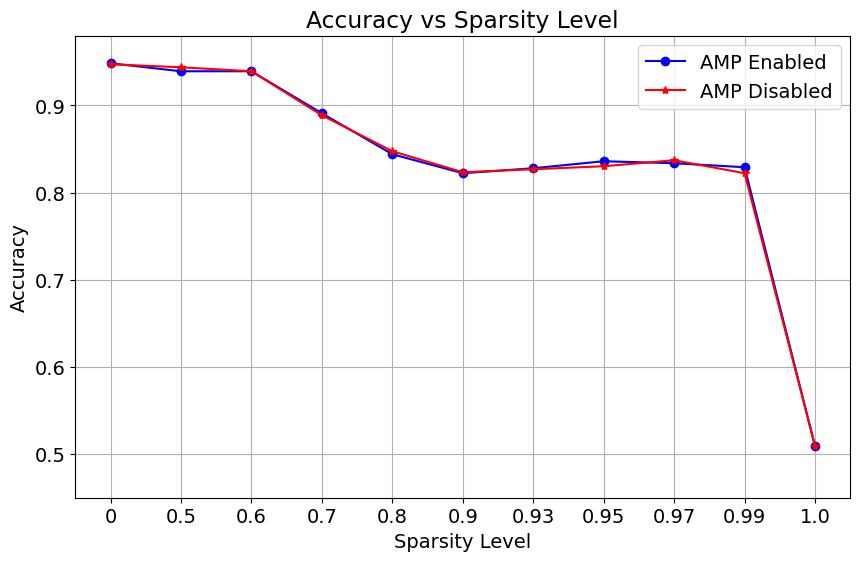

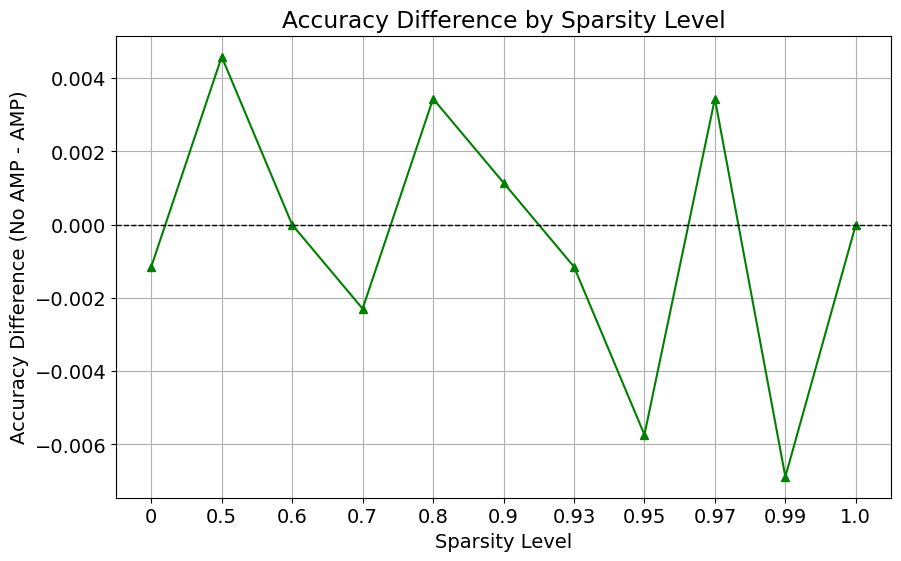

acc_diff [-0.00114679  0.00458716  0.         -0.00229358  0.00344037  0.00114679
 -0.00114679 -0.00573394  0.00344037 -0.00688073  0.        ]


In [2]:
import matplotlib.pyplot as plt
import numpy as np

# 가상의 데이터 생성
sparsity_levels = [0, 0.5, 0.6, 0.7, 0.8, 0.9, 0.93, 0.95, 0.97, 0.99, 1.0]
acc_amp = [0.948394495412844, 0.9392201834862385, 0.9392201834862385, 0.8910550458715596, 0.8440366972477065, 0.8222477064220184, 0.8279816513761468, 0.8360091743119266, 0.8337155963302753 , 0.8291284403669725, 0.5091743119266054 ]
acc_no_amp = [0.9472477064220184, 0.9438073394495413, 0.9392201834862385, 0.8887614678899083, 0.8474770642201835, 0.823394495412844, 0.8268348623853211, 0.8302752293577982, 0.8371559633027523, 0.8222477064220184, 0.5091743119266054 ]

# 정확도 차이 계산
acc_diff = np.array(acc_no_amp) - np.array(acc_amp)

# 정확도 비교 그래프 (X축 비율 조정)
plt.figure(figsize=(10, 6))

# X축 비율을 동일하게 조정하기 위해 sparsity_levels의 비율을 재설정
sparsity_levels_index = np.linspace(0, 1, len(sparsity_levels))
plt.plot(sparsity_levels_index, acc_amp, 'bo-', label='AMP Enabled')
plt.plot(sparsity_levels_index, acc_no_amp, 'r*-', label='AMP Disabled')
plt.xlabel('Sparsity Level')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Sparsity Level')
plt.legend()
plt.grid(True)
plt.xticks(sparsity_levels_index, sparsity_levels)  # X축에 원래 sparsity 레벨 레이블 설정
plt.ylim(0.45, 0.98)  # y축 범위 설정
plt.savefig('accuracy_comparison_equal_spacing.png', dpi=300)
plt.show()

# 정확도 차이 그래프 (X축 비율 조정)
plt.figure(figsize=(10, 6))
plt.plot(sparsity_levels_index, acc_diff, 'g^-')
plt.xlabel('Sparsity Level')
plt.ylabel('Accuracy Difference (No AMP - AMP)')
plt.title('Accuracy Difference by Sparsity Level')
plt.grid(True)
plt.xticks(sparsity_levels_index, sparsity_levels)  # X축에 원래 sparsity 레벨 레이블 설정
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.savefig('accuracy_difference_equal_spacing.png', dpi=300)
plt.show()

print('acc_diff', acc_diff)

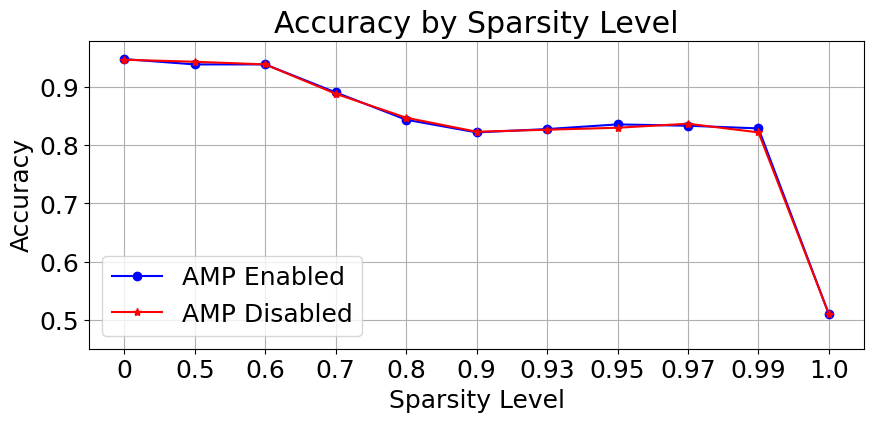

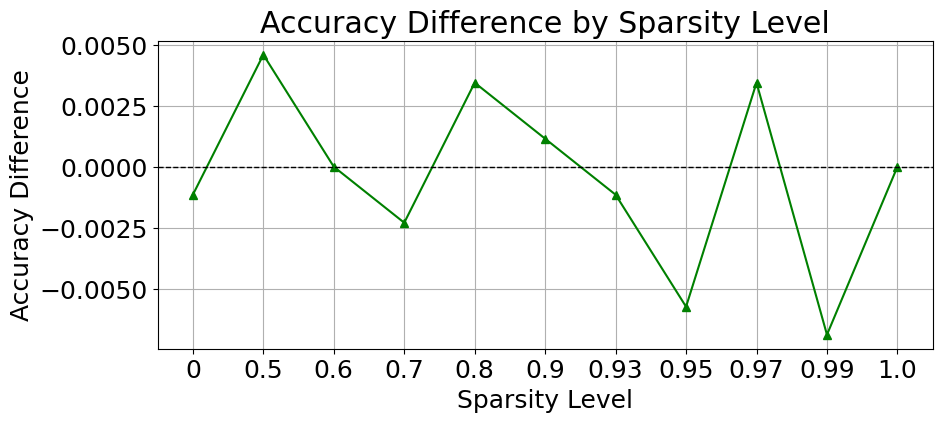

acc_diff [-0.00114679  0.00458716  0.         -0.00229358  0.00344037  0.00114679
 -0.00114679 -0.00573394  0.00344037 -0.00688073  0.        ]


In [10]:
# 전역 글꼴 크기 설정
plt.rcParams.update({'font.size': 18})  # 전체 글자 크기를 14로 설정

sparsity_levels_index = np.linspace(0, 1, len(sparsity_levels))

# 첫 번째 그래프: Accuracy by Sparsity Level
plt.figure(figsize=(10, 4))
plt.plot(sparsity_levels_index, acc_amp, 'bo-', label='AMP Enabled')
plt.plot(sparsity_levels_index, acc_no_amp, 'r*-', label='AMP Disabled')
plt.xlabel('Sparsity Level')
plt.ylabel('Accuracy')
plt.title('Accuracy by Sparsity Level')
plt.legend()
plt.grid(True)
plt.xticks(sparsity_levels_index, sparsity_levels)  # X축에 원래 sparsity 레벨 레이블 설정
plt.ylim(0.45, 0.98)  # y축 범위 설정
plt.savefig('accuracy_comparison_equal_spacing.png', dpi=300)
plt.show()

# 두 번째 그래프: Accuracy Difference by Sparsity Level
plt.figure(figsize=(10, 4))
plt.plot(sparsity_levels_index, acc_diff, 'g^-')
plt.xlabel('Sparsity Level')
plt.ylabel('Accuracy Difference')
plt.title('Accuracy Difference by Sparsity Level')
plt.grid(True)
plt.xticks(sparsity_levels_index, sparsity_levels)  # X축에 원래 sparsity 레벨 레이블 설정
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.savefig('accuracy_difference_equal_spacing.png', dpi=300)
plt.show()

print('acc_diff', acc_diff)

In [25]:
!pip list

Package                  Version
------------------------ ----------------
about-time               4.2.1
absl-py                  2.1.0
accelerate               0.33.0
aiohappyeyeballs         2.3.4
aiohttp                  3.10.1
aiosignal                1.3.1
alive-progress           3.1.4
appdirs                  1.4.4
asttokens                2.4.1
async-timeout            4.0.3
attrs                    21.2.0
autograd                 1.6.2
Automat                  20.2.0
Babel                    2.8.0
bcrypt                   3.2.0
blinker                  1.7.0
build                    1.2.1
catboost                 1.2.3
category-encoders        2.6.3
certifi                  2020.6.20
chardet                  4.0.0
charset-normalizer       3.3.2
click                    8.1.7
cloud-init               24.1.3
cloudpickle              3.0.0
cma                      3.2.2
cmake                    3.27.2
colorama                 0.4.4
comm                     0.2.1
command-not-foun

In [29]:
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable
